In [23]:
from google.datalab import Context
import google.datalab.bigquery as bq
import google.datalab.storage as storage
import pandas as pd
import numpy as np
import spc as pc
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO
import matplotlib.pyplot as plt
%matplotlib inline

Please consider only 2007 & 2008 from stats to solve below questions:
* Which Carrier performs better?
* When is the best time of day/day of week/time of year to fly to minimise delays?
* Do older planes suffer more delays?
* Can you detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?
* Create a model to predict flight delays?
* How well does weather predict plane delays?

### Below code is to extract files from internet and unzip them

In [ ]:
import requests,bz2,os
def pull_decompress(year):
  '''
  This function downloads file to local drive and decompresses the file. This has function takes argument as the year from 1988 to 2008
  '''
  try:
    url= "http://stat-computing.org/dataexpo/2009/"+str(year)+".csv.bz2"
    r =requests.get(url)
    try:
      os.remove(str(year)+'.csv.bz2')
      os.remove(str(year)+'.csv')
    except OSError:
      pass
    with open(str(year)+'.csv.bz2','wb') as f:
      f.write(r.content)
    data=bz2.BZ2File(str(year)+'.csv.bz2','rb').read()
    open(str(year)+'.csv','wb').write(data)
    return True
  except IOError:
    return False
    

### Downloading Data from  sources using bash commands

In [ ]:
!wget "http://stat-computing.org/dataexpo/2009/airports.csv"
!wget "http://stat-computing.org/dataexpo/2009/carriers.csv"
!wget "http://stat-computing.org/dataexpo/2009/plane-data.csv"
!wget "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
!bzip2 -d '2008.csv.bz2'
!wget "http://stat-computing.org/dataexpo/2009/2007.csv.bz2"
!bzip2 -d '2007.csv.bz2'

### Loading data from local drive to dataframe

In [9]:
df_2008=pd.read_csv('2008.csv')
df_2007=pd.read_csv('2007.csv')
airport_df=pd.read_csv('airports.csv')
carrier_df=pd.read_csv('carriers.csv')
planes_df=pd.read_csv('plane-data.csv')
main_df=pd.concat([df_2008,df_2007],ignore_index=True)

#### Details of Data 

In [3]:
print(df_2008.shape,df_2007.shape)
main_df.info()

(7009728, 29) (7453215, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14462943 entries, 0 to 14462942
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)

In [34]:
pd.options.display.float_format = '{:.04f}'.format
imp_col=['Cancelled','ArrDelay','DepDelay','AirTime','Distance','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
main_df[imp_col].describe().T
#main_df[['NASDelay','SecurityDelay','LateAircraftDelay']].describe()
#temp=main_df.styles.format()
#main_df[main_df['AirTime']==0].groupby('UniqueCarrier')['ArrTime'].count()
#main_df[main_df['Cancelled']==1].groupby('UniqueCarrier')['UniqueCarrier'].count()
#main_df[main_df['AirTime']==0][['UniqueCarrier','DepTime','CRSDepTime','ArrTime','AirTime']]

,count,mean,std,min,25%,50%,75%,max
Cancelled,14462943.0000,0.0206,0.1421,0.0000,0.0000,0.0000,0.0000,1.0000
ArrDelay,14130317.0000,9.2104,38.9320,-519.0000,-10.0000,-1.0000,13.0000,2598.0000
DepDelay,14165949.0000,10.7070,35.7484,-534.0000,-4.0000,-1.0000,9.0000,2601.0000
AirTime,14130317.0000,103.3994,67.8586,0.0000,55.0000,85.0000,131.0000,1350.0000
Distance,14462943.0000,722.9955,562.2162,11.0000,323.0000,576.0000,948.0000,4962.0000
Diverted,14462943.0000,0.0024,0.0487,0.0000,0.0000,0.0000,0.0000,1.0000
CarrierDelay,8977950.0000,5.8874,25.5675,0.0000,0.0000,0.0000,0.0000,2580.0000
WeatherDelay,8977950.0000,1.1554,11.9224,0.0000,0.0000,0.0000,0.0000,1429.0000
NASDelay,8977950.0000,6.0562,20.3778,0.0000,0.0000,0.0000,0.0000,1386.0000
SecurityDelay,8977950.0000,0.0324,1.2455,0.0000,0.0000,0.0000,0.0000,392.0000


In [5]:
#F9 has lowest percentage of Cancellations compages to all the Carriers
#Total cancelled flights are 2.061
#main_df[main_df['Cancelled']==1].shape[0]/main_df.shape[0]
Cancel_series=pd.Series(main_df[main_df['Cancelled']==1]['UniqueCarrier'].value_counts()/main_df['UniqueCarrier'].value_counts()).sort_values()

Text(0.5,1,'Percentage of cancelled flights from each carrier')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


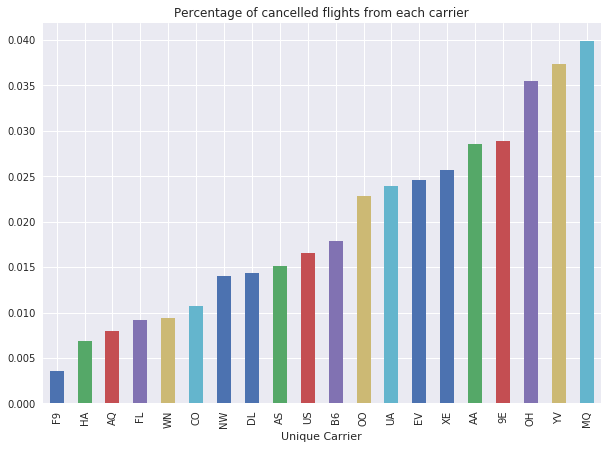

In [6]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(111)
Cancel_series.plot(kind='bar',ax=ax)
ax.set_xlabel('Unique Carrier')
ax.set_title('Percentage of cancelled flights from each carrier')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


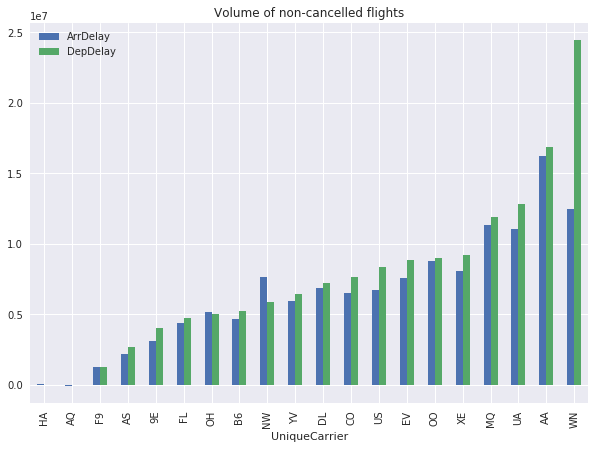

In [7]:
Non_cacel=main_df[main_df['Cancelled']==0]
Non_cacel[['UniqueCarrier','ArrDelay','DepDelay']].groupby(['UniqueCarrier']).sum().sort_values(by='DepDelay').plot(kind='bar',figsize=(10,7),title='Volume of non-cancelled flights')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


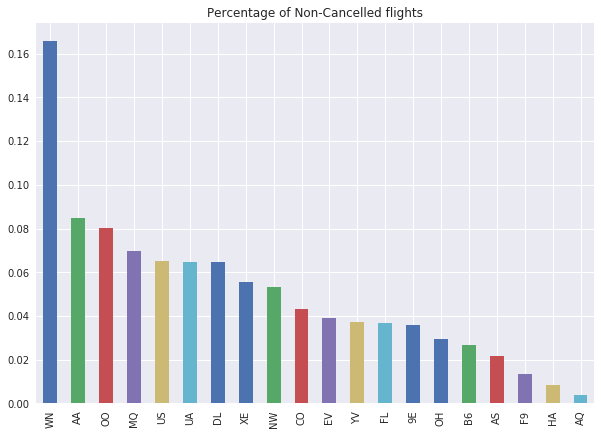

In [8]:
pd.Series(Non_cacel['UniqueCarrier'].value_counts()/Non_cacel.shape[0]).plot(kind='bar',figsize=(10,7),title="Percentage of Non-Cancelled flights")

#### Below are functions which provide mathematical model/weighted average model to find performance of carrier

In [ ]:
def group_car(main_df):
  cancel_df=main_df[main_df['Cancelled']==1]['UniqueCarrier'].value_counts()/main_df['UniqueCarrier'].value_counts()
  non_cancel=main_df[main_df['Cancelled']==0]
  delay_dept=non_cancel[(non_cancel['DepDelay']!=0) |(non_cancel['ArrDelay']!=0)].groupby('UniqueCarrier')['DepDelay'].count()/non_cancel['UniqueCarrier'].value_counts()
  share_flight=non_cancel['UniqueCarrier'].value_counts()/non_cancel.shape[0]
  non_cancel['squared_val_Dep_delay']= non_cancel['DepDelay']**2
  non_cancel['squared_val_Arr_delay']=non_cancel['ArrDelay']**2
  total_delay=np.sqrt(non_cancel.groupby('UniqueCarrier')['squared_val_Dep_delay'].sum()/non_cancel['UniqueCarrier'].value_counts())+np.sqrt(non_cancel.groupby('UniqueCarrier')['squared_val_Arr_delay'].sum()/non_cancel['UniqueCarrier'].value_counts())
  final_del_data=pd.concat([share_flight,cancel_df,delay_dept,total_delay],axis=1,ignore_index=False)
  final_del_data.columns=['flight_share','Cacel_per','dep_del_per','total_delay']
  #Arr_delay=np.sqrt(non_cancel.groupby('UniqueCarrier')['squared_val_Arr_delay'].sum()/non_cancel['UniqueCarrier'].value_counts())
  return final_del_data

def perform_eval(df):
  ''' This function should contain a calculative model which can measure performance of carries
  based on number of cancellation per year, 
  number of delayed departure,
  percentage of flights its making, absolute number of total minutes of delayed departure
  f(x)= 0.35*per_cancell+0.25*delay_departure+0.25*share_of_flights+0.15*squared_val_delayed
  '''
  df['Non_Perform_index']=0.35*df['Cacel_per']+0.15*df['dep_del_per']+0.15*(1/df['flight_share'])+0.35*df['total_delay']
  #df['Perform_index']=0.35*df['Cacel_per']+0.3*df['dep_del_per']+0.35*df['total_delay']
  global carrier_df
  if 'Code' in carrier_df.columns:
    carrier_df.set_index('Code',inplace=True)
  df=df.merge(carrier_df,how='left',left_index=True,right_index=True)
  df= df.sort_values(by='Non_Perform_index',ascending=True)
  return df
def HighPerform_carrier(df):
  '''The input for this function is from perform_eval'''
  return(df['Description'][0],df['Non_Perform_index'][0])

def Perform_full(main_df):
  return HighPerform_carrier(perform_eval(group_car(main_df)))

In [ ]:
#data_final= group_car(main_df)
#data_final_eval=perform_eval(data_final)
#This line of code provides High performing carrier
name,index=Perform_full(main_df)
print("The High performance Carrier is {} and its score of index is {:.2f}".format(name,index))

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Below is statistical model to check carrier performance </br>


###### The methodology for this is:

**Statistical functions to calculate UCL, LCL and mean value of population**

In [7]:
#df_2008_1=df_2008.set_index('Date')
f = lambda x: np.max(x)-np.min(x)
def x_bar(x):
  return np.mean(x)/np.size(x)
def x_mean(x):
  return np.max(x)-np.min(x)
def x_Ucl(x):
  return np.mean(x)/np.size(x)+((np.max(x)-np.min(x))*3/(3.931*np.sqrt(25)))
def x_Lcl(x):
  return np.mean(x)/np.size(x)-((np.max(x)-np.min(x))*3/(3.931*np.sqrt(25)))
def x_test(x):
  ucl=x_Ucl(x)
  lcl=x_Lcl(x)
  return np.sum((x>ucl)|(x<lcl))/np.size(x)
week_dict= {1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',7:'Sunday'}
month_dict= {1:'January',2:'Febraury',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

Q1. **Which carrier performs better?**

In [32]:
non_cancel=main_df[(main_df['Cancelled']==0) & (main_df['UniqueCarrier']!='AQ')]
non_cancel['Date']= pd.to_datetime(pd.DataFrame({'year':non_cancel['Year'],'month':non_cancel['Month'],'day':non_cancel['DayofMonth']}))
sample_data=non_cancel[['Date','UniqueCarrier','DepDelay','ArrDelay']].groupby(['Date','UniqueCarrier']).apply(lambda x: x.sample(n=25,random_state=100,replace=False).mean()).reset_index()
carrier_sel=sample_data[['UniqueCarrier','DepDelay','ArrDelay']].groupby('UniqueCarrier').agg([x_bar,x_Lcl,x_Ucl,x_test])
carrier_sel.columns = ['_'.join(col) for col in carrier_sel.columns]
carrier_sel['Final_test']= (carrier_sel['DepDelay_x_test']+carrier_sel['ArrDelay_x_test'])/2
carrier_sel=carrier_sel.sort_values(by='Final_test',ascending=True)
if 'Code' in carrier_df.columns:
    carrier_df.set_index('Code',inplace=True)
carrier_sel=carrier_sel.merge(carrier_df,how='left',left_index=True,right_index=True)
print("Best carrier with minimal delays is {} and worst carrier with major delay is {}".format(carrier_sel['Description'][0],carrier_sel['Description'][-1]))
#non_cancel_avg.head(10)

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Best carrier with minimal delays is Hawaiian Airlines Inc. and worst carrier with major delay is Mesa Airlines Inc.


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


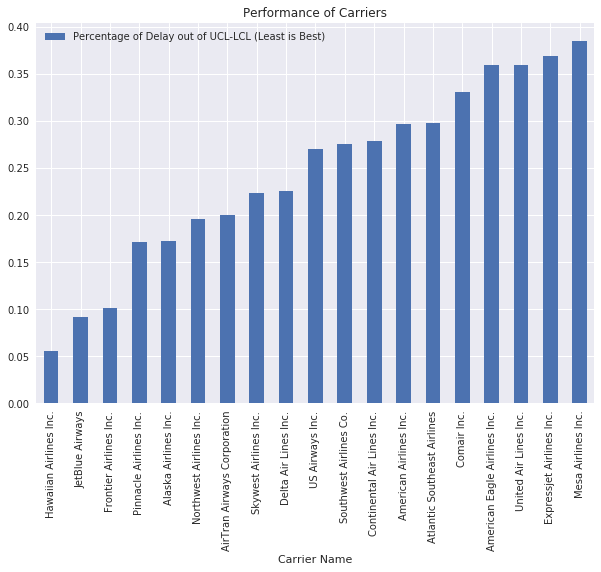

In [33]:
carrier_list= carrier_sel[['Description','Final_test']].reset_index()
carrier_list.columns=['Carrier Code','Carrier Name','Percentage of Delay out of UCL-LCL (Least is Best)']
carrier_list=carrier_list.set_index('Carrier Name')
carrier_list[['Percentage of Delay out of UCL-LCL (Least is Best)']].plot(kind='bar',figsize=(10,7),title='Performance of Carriers')

Q2. **When is the best time of day/day of week/time of year to fly to minimise delays?**

In [13]:
sample_data=non_cancel[['Date','DayOfWeek','DepDelay','ArrDelay']].groupby(['Date','DayOfWeek']).apply(lambda x: x.sample(n=25,random_state=100,replace=False).mean()).reset_index(drop=True)
#sample_data= non_cancel_avg.groupby('DayOfWeek')
#sample_data.head(10)
sample_data_Dow=sample_data[['DayOfWeek','DepDelay','ArrDelay']].groupby('DayOfWeek').agg([x_bar,x_Lcl,x_Ucl,x_test])
sample_data_Dow.columns = ['_'.join(col) for col in sample_data_Dow.columns]
sample_data_Dow['Final_test']= (sample_data_Dow['DepDelay_x_test']+sample_data_Dow['ArrDelay_x_test'])/2
sample_data_Dow=sample_data_Dow.sort_values(by='Final_test',ascending=True)
print("Best time to minimize delays is to travel on {} day of week".format(week_dict[sample_data_Dow.index[0]]))

Best time to minimize delays is to travel on Sunday day of week


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


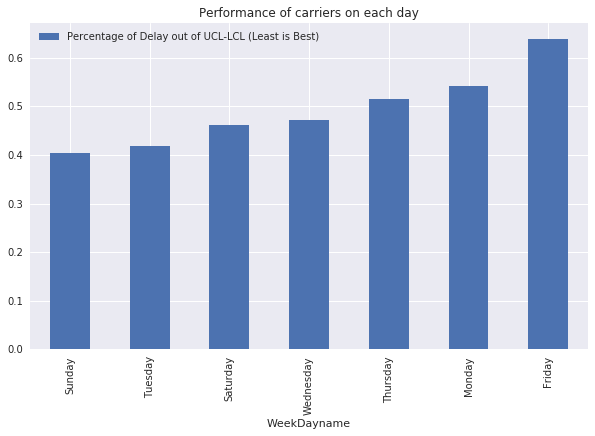

In [14]:
sample_data_Dow.reset_index()[['DayOfWeek','Final_test']]
Days_list= sample_data_Dow.reset_index()[['DayOfWeek','Final_test']]
Days_list.columns=['DayOfWeek','Percentage of Delay out of UCL-LCL (Least is Best)']
Days_list.loc[:,'WeekDayname']= Days_list['DayOfWeek'].apply(lambda x:week_dict[x])
Days_list=Days_list[['WeekDayname','DayOfWeek','Percentage of Delay out of UCL-LCL (Least is Best)']].set_index('WeekDayname')
Days_list[['Percentage of Delay out of UCL-LCL (Least is Best)']].plot(kind='bar',figsize= (10,6),title='Performance of carriers on each day')

In [15]:
sample_data=non_cancel[['Date','Month','DepDelay','ArrDelay']].groupby(['Date']).apply(lambda x: x.sample(n=25,random_state=100,replace=False).mean()).reset_index(drop=True)
#sample_data= non_cancel_avg.groupby('Month')
#sample_data.head(10)
sample_data_Mnth=sample_data[['Month','DepDelay','ArrDelay']].groupby('Month').agg([x_bar,x_Lcl,x_Ucl,x_test])
sample_data_Mnth.columns = ['_'.join(col) for col in sample_data_Mnth.columns]
sample_data_Mnth['Final_test']= (sample_data_Mnth['DepDelay_x_test']+sample_data_Mnth['ArrDelay_x_test'])/2
sample_data_Mnth=sample_data_Mnth.sort_values(by='Final_test',ascending=True)
print("Best time to minimize delays is to travel in {} month".format(month_dict[sample_data_Mnth.index[0]]))

Best time to minimize delays is to travel in November month


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


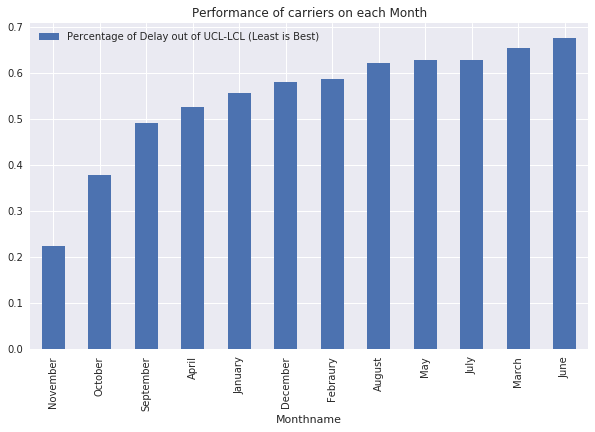

In [17]:
sample_data_Mnth.reset_index()[['Month','Final_test']]
Months_list= sample_data_Mnth.reset_index()[['Month','Final_test']]
Months_list.columns=['Month','Percentage of Delay out of UCL-LCL (Least is Best)']
Months_list.loc[:,'Monthname']= Months_list['Month'].apply(lambda x:month_dict[x])
Months_list=Months_list[['Monthname','Month','Percentage of Delay out of UCL-LCL (Least is Best)']].set_index('Monthname')
Months_list[['Percentage of Delay out of UCL-LCL (Least is Best)']].plot(kind='bar',figsize= (10,6),title='Performance of carriers on each Month')

In [ ]:
carrier_sel.to_csv('Carrier_results.csv')
sample_data_Dow.to_csv('Scores for individual_date.csv')
sample_data_Mnth.to_csv('Scores for individual_month.csv')

In [ ]:
# Finding the probability of cancellation of flight for each carrier from the data
#import scipy. probability of cancellation is 0.02,
def prob(x):
  #r=np.sum(x==1)
  return np.sum(x==1)/np.size(x)
sample_data= main_df.sample(frac=0.6,replace=False)['Cancelled'].copy()
cancel_prob =sample_data.value_counts()/sample_data.shape[0]
print(cancel_prob[1])

Q3. **Do older planes suffer more delays?**

In [ ]:
# Planes delay is same for older and newer planes
# Alternate hypothesis is older planes do suffer more delay
# confidence level is 95%,so alpha is 0.05%
planes_df1=planes_df[planes_df['type'].isnull()==False]
main_df_planes= main_df.merge(planes_df1[['tailnum','year']],how='left',left_on='TailNum',right_on='tailnum')
from scipy.stats import chisquare
main_df_planes['Delayed']= np.where((main_df_planes['DepDelay']!=0) |(main_df_planes['ArrDelay']!=0),1,0)
chi,p =chisquare(np.array(main_df_planes.groupby(['year'])['Delayed'].sum()))
print("P value {:.6f}".format(p))
if p <0.05:
  print("There sufficient evidence to regect null hypothes")
else:
  print("There  no sufficient evidence to reject null hypothes")
#Since null hypothesis is rejected, we can say older planes suffer more delay.

As per above chisquare test, its provide that we can regect null hypothesis and say carries delays are not indepent of year of manufacturing year. So its provide that older planes cause delay.

In [3]:
!gsutil cp Carrier_results.csv gs://srimldatapoint/
#!gsutil cp Scores* gs://srimldatapoint/

Copying file://Carrier_results.csv [Content-Type=text/csv]...
- [1 files][  4.0 KiB/  4.0 KiB]                                                
Operation completed over 1 objects/4.0 KiB.                                      


Q4. **Can you detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?**
